# Chapter 6 – Decision Trees 

- 5장과 마찬가지로 복잡한 데이터 set을 fitting 할수 있는 아주 강력한 알고리즘
- 7장의 Random Forests의 기본 구성 요소
- 의사결정 트리는 기계학습의 대표적인 Supervised Learning 방법으로 분류(classification) 문제를 다룬다. 


1) 결정 트리의 학습, 시각화, 예측 방법에 대해<br>
2) Scikit-Learn에서 사용하는 CART 학습 알고리즘 및 정규화, 회귀 작업 방법에 대해<br>
3) Decision Trees의 한계점에 대해


# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [7]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"

def image_path(fig_id):
    return os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id)

def save_fig(fig_id, tight_layout=True):
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(image_path(fig_id) + ".png", format='png', dpi=300)

# 1. Training and visualizing

예측 트리 생성 -> 예측을 어떻게 하는지 
- Decision Tree Classifier를 통해서 학습시킨다

In [8]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:] # 꽃잎의 길이 & 넓이
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

iris_dot 그래프 파일을 출력하여 의사결정트리를 시각화한다. 

In [9]:
from sklearn.tree import export_graphviz

export_graphviz(
        tree_clf,
        out_file=image_path("iris_tree.dot"),
        feature_names=iris.feature_names[2:],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

<img src='decisiontree.PNG'>

c:\users\ejjch\appdata\local\programs\python\python36\lib\site-packages\matplotlib\contour.py:967: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


Saving figure decision_tree_decision_boundaries_plot


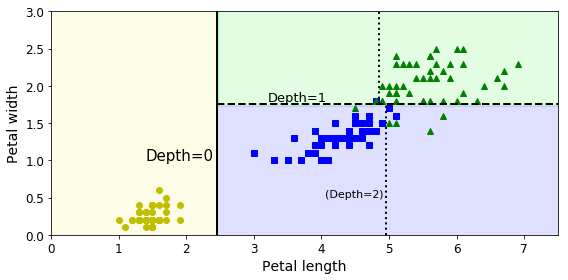

In [16]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap, linewidth=10)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris-Setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris-Versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris-Virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11)

save_fig("decision_tree_decision_boundaries_plot")
plt.show()

위 그림은 decision Tree의 decision boundary를 보여줌

-Depth=0 : Root node 경계 petal length = 2.45cm (pure, Only Iris-Sentosa) 더이상 분할할 수 없다 <br>
-Depth=1 : 오른쪽 영역의 petal width = 1.75cm 로 분할

# Estimating Class Probabilities

특징 
- 특별히 많은 데이터 준비가 필요하지 않는다.
- feature scaling과 center로 모으는 작업이 필요하지 않다.

<img src='decisiontree.PNG'>

1. sample수는 얼마나 많은 학습 인스턴스가 적용되었는지를 보여준다. <br>
    Ex. 150개 중 50개는 2.45cm보다 작고 나머지 100개는 2.45cm보다 크다.

2. value는 노드가 적용되는 각 클래스의 학습 인스턴스 수를 나타낸다.<br>
    ex. 초록색 : 분류된 54개의 샘플 중 versicolor로 분류된 인스턴스는 49개 2(virginica)로 분류된 샘플수는 5개라는 것을 의미

3. gini는 불순도(impurity)를 측정한다. <br>
    ex. 모든 학습 인스턴스가 같은 클래스에 속하면 gini=0이며 노드는 'pure'다.
    
**Gini Impurity ** <br>
$G_i = 1- \sum_{k=1}^n {P_{i,k}^2}$


**또한, Decision Tree를 사용해서 특정 클래스 k에 속할 확률을 구할 수 있다. **
#### Example
꽃잎 길이가 5cm & 넓이가 1.5cm 인 instance <br>
Depth-2, left 에 속한다  <br>
<img src='estimating.PNG'>
    이때의 확률은 0% (Iris-Setosa 0/54),   90.7%(Iris-Versicolor 49/54),    9.3%(Iris-Virginica 5/54) 이며 <br>
    예측 클래스는 확률이 제일 높은 class 1을 나타낸다

In [17]:
# 확률 출력
tree_clf.predict_proba([[5, 1.5]])

array([[ 0.        ,  0.90740741,  0.09259259]])

In [18]:
# 속하는 클래스 출력
tree_clf.predict([[5, 1.5]])

array([1])

# The CART Training Algorithm

 Scikit Learn은 CART(CART : Classification And Regression Tree) 알고리즘을 사용해 Decision Tree를 학습시킨다. <br>
 CART는 학습 set를 두개의 subset으로 분할한다. 
 - 단일 feature K : 꽃잎 길이 / 임계값 threshold tk : 2.45
 

(단일 feature K, 임계값 tk)을 선택하는 방법은 먼저 순수한 부분집합(pure subsets) 쌍을 찾는다. <br>
학습 set를 성공적으로 분할하면 계속해서 하위 집합을 분할하여 max depth에 도달하거나 impurity를 줄이는 분할을 찾지 못할 경우 중지한다. 



# Computational Complexity

예측을 위해 Decision Tree의 root에서 leaf 까지 이동한다. 


# Gini Impurity or Entropy?
엔트로피는 데이터가 지저분할 수록 그 값이 크다. 
Entropy : $H_i = - \sum_{{k=1, P_{i,k=0}}^n} {P_{i,k}log({P_{i,k}})}$

- Gini Impurity는 속도가 약간 빠르고 기본값으로 설정되어있다. 
- 그러나 Gini 는 트리 분기에서 가장 빈번한 클래스를 고립시키는 경향이 있고 Entropy는 좀 더 균형잡혀 있다는 특징이 있다. 

# Sensitivity to training set details

In [19]:
X[(X[:, 1]==X[:, 1][y==1].max()) & (y==1)] # widest Iris-Versicolor flower

array([[ 4.8,  1.8]])

In [20]:
not_widest_versicolor = (X[:, 1]!=1.8) | (y==2)
X_tweaked = X[not_widest_versicolor]
y_tweaked = y[not_widest_versicolor]

tree_clf_tweaked = DecisionTreeClassifier(max_depth=2, random_state=40)
tree_clf_tweaked.fit(X_tweaked, y_tweaked)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=40,
            splitter='best')

c:\users\ejjch\appdata\local\programs\python\python36\lib\site-packages\matplotlib\contour.py:967: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


Saving figure decision_tree_instability_plot


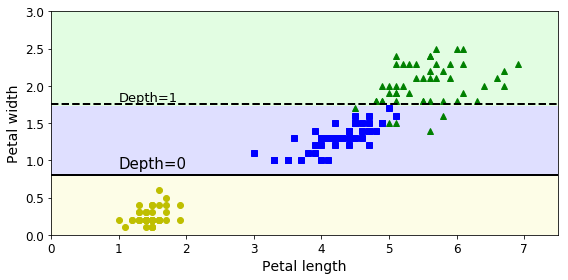

In [21]:
plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf_tweaked, X_tweaked, y_tweaked, legend=False)
plt.plot([0, 7.5], [0.8, 0.8], "k-", linewidth=2)
plt.plot([0, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.text(1.0, 0.9, "Depth=0", fontsize=15)
plt.text(1.0, 1.80, "Depth=1", fontsize=13)

save_fig("decision_tree_instability_plot")
plt.show()

# Regularization Hyperparameters

의사결정 트리는 학습데이터에 대해 가정하지 않기 때문에 overfitting 되기가 쉽다 (이런 모델을 nonparametric model이라 한다)

선형모델(Linear Model)과 같은 parametric model은 매개변수를 가지므로 자유도가 제한되고 overfitting위험을 줄일 수 있다. 

- Overfitting을 줄이기 위해 학습하는 동안 결정 트리의 freedom을 제한 : 정규화 (regularization)
- 의사결정 트리의 경우 주로 Maximum Depth를 제한하여 정규화한다. Max_depth를 줄이면 overfitting위험 감소

### Decision Tree Classifier의 결정트리 모양 제한하는 매개변수
1) min_samples_split : 노드가 분할되기 전에 가지고 있어야하는 샘플의 최소 개수<br>
2) min_samples_leaf : leaf 노드에 있어야 하는 샘플의 최소 개수<br>
3) min_weight_fraction_leaf : 2번과 같은의미. 가중치가 부여된 인스턴스의 총 개수를 부분(fraction)으로 표현<br>
4) max_leaf_nodes : leaf노드의 최대 개수<br>
5) max_features : 각 노드 분할에 평가되는 최대 feature 수 <br>

**min_* hyperparameter를 늘리거나 max_* hyperparameter를 줄이면서 모델을 정규화한다.**


c:\users\ejjch\appdata\local\programs\python\python36\lib\site-packages\matplotlib\contour.py:967: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


Saving figure min_samples_leaf_plot


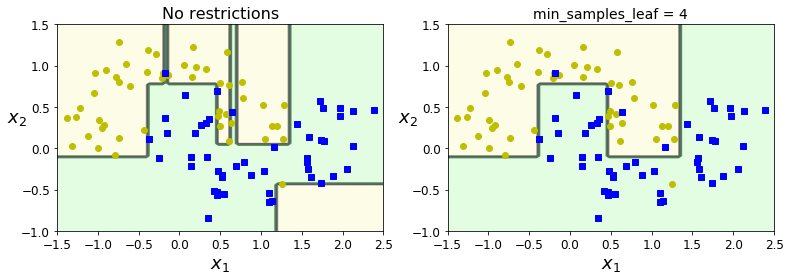

In [22]:
from sklearn.datasets import make_moons
Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

deep_tree_clf1 = DecisionTreeClassifier(random_state=42)
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
deep_tree_clf1.fit(Xm, ym)
deep_tree_clf2.fit(Xm, ym)

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_decision_boundary(deep_tree_clf1, Xm, ym, axes=[-1.5, 2.5, -1, 1.5], iris=False)
plt.title("No restrictions", fontsize=16)
plt.subplot(122)
plot_decision_boundary(deep_tree_clf2, Xm, ym, axes=[-1.5, 2.5, -1, 1.5], iris=False)
plt.title("min_samples_leaf = {}".format(deep_tree_clf2.min_samples_leaf), fontsize=14)

save_fig("min_samples_leaf_plot")
plt.show()

왼쪽은 기본 하이퍼 매개변수로 학습된것 VS 오른쪽은 min_samples_leaf가 4로 학습된 것

왼쪽은 오버 피팅된 모습이며 오른쪽은 일반화가 잘 이루어짐

c:\users\ejjch\appdata\local\programs\python\python36\lib\site-packages\matplotlib\contour.py:967: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


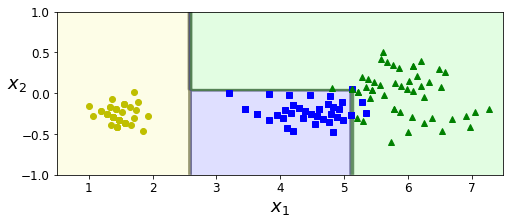

In [23]:
angle = np.pi / 180 * 20
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xr = X.dot(rotation_matrix)

tree_clf_r = DecisionTreeClassifier(random_state=42)
tree_clf_r.fit(Xr, y)

plt.figure(figsize=(8, 3))
plot_decision_boundary(tree_clf_r, Xr, y, axes=[0.5, 7.5, -1.0, 1], iris=False)

plt.show()

# Regression trees
Decision Tree도 회귀 작업을 할 수 있다. DecisionTreeRegression 클래스 사용

In [25]:
# Quadratic training set + noise
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

In [26]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

<img src = 'regression.PNG'>

분류 트리와 매우 유사하며 차이점은 각 노드의 클래스를 예측하는 대신 값을 예측한다


Saving figure tree_regression_plot


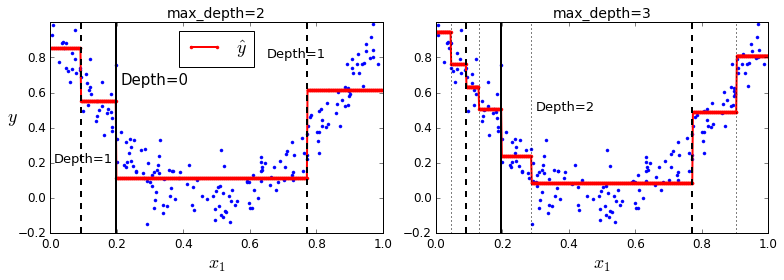

In [15]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_regression_predictions(tree_reg1, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, "Depth=0", fontsize=15)
plt.text(0.01, 0.2, "Depth=1", fontsize=13)
plt.text(0.65, 0.8, "Depth=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

plt.subplot(122)
plot_regression_predictions(tree_reg2, X, y, ylabel=None)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.5, "Depth=2", fontsize=13)
plt.title("max_depth=3", fontsize=14)

save_fig("tree_regression_plot")
plt.show()

각 영역의 예측 값은 해당 영역의 인스턴스의 평균 목표값<br>
max_depth의 크기에 따라 예측 값이 다르다

In [27]:
export_graphviz(
        tree_reg1,
        out_file=image_path("regression_tree.dot"),
        feature_names=["x1"],
        rounded=True,
        filled=True
    )

NameError: name 'tree_reg1' is not defined

Saving figure tree_regression_regularization_plot


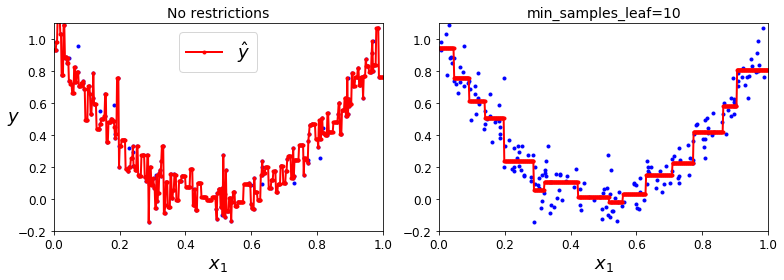

In [31]:
tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

x1 = np.linspace(0, 1, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(X, y, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize=18, rotation=0)
plt.legend(loc="upper center", fontsize=18)
plt.title("No restrictions", fontsize=14)

plt.subplot(122)
plt.plot(X, y, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.title("min_samples_leaf={}".format(tree_reg2.min_samples_leaf), fontsize=14)

save_fig("tree_regression_regularization_plot")
plt.show()

분류와 마찬가지로 over fitting 되기 쉽다. <br>
min_samples_leaf를 10으로 설정하면 합리적 모델이 생성

# Instability 불안정성
Decision Tree는 수직적으로 경계를 형성하는 경계를 내리는 편이다. <br>
이때, 단순 선형 분리 데이터가 아닌 회전된 데이터의 경우 결정경계가 불필요하게 복잡해진다. <br>
또한 데이터의 작은 변화에도 민감하다. 즉 동일 학습 데이터에 대해서도 매우 다른 모델을 얻을 수 있게 된다 <br>
(random_state를 설정하지 않는 한)

c:\users\ejjch\appdata\local\programs\python\python36\lib\site-packages\matplotlib\contour.py:967: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


Saving figure sensitivity_to_rotation_plot


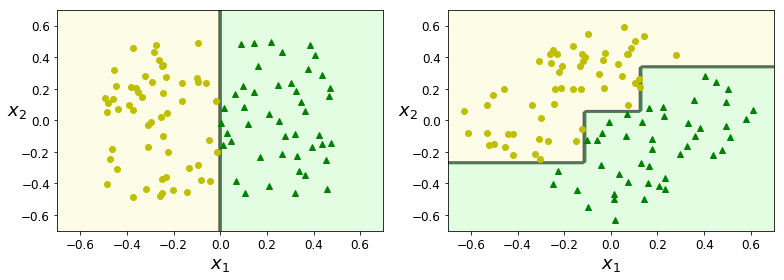

In [24]:
np.random.seed(6)
Xs = np.random.rand(100, 2) - 0.5
ys = (Xs[:, 0] > 0).astype(np.float32) * 2

angle = np.pi / 4
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xsr = Xs.dot(rotation_matrix)

tree_clf_s = DecisionTreeClassifier(random_state=42)
tree_clf_s.fit(Xs, ys)
tree_clf_sr = DecisionTreeClassifier(random_state=42)
tree_clf_sr.fit(Xsr, ys)

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_decision_boundary(tree_clf_s, Xs, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.subplot(122)
plot_decision_boundary(tree_clf_sr, Xsr, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)

save_fig("sensitivity_to_rotation_plot")
plt.show()

# Exercise solutions

## 1. to 6.

See appendix A.

## 7.

_Exercise: train and fine-tune a Decision Tree for the moons dataset._

a. Generate a moons dataset using `make_moons(n_samples=10000, noise=0.4)`.

Adding `random_state=42` to make this notebook's output constant:

In [18]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=10000, noise=0.4, random_state=42)

b. Split it into a training set and a test set using `train_test_split()`.

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

c. Use grid search with cross-validation (with the help of the `GridSearchCV` class) to find good hyperparameter values for a `DecisionTreeClassifier`. Hint: try various values for `max_leaf_nodes`.

In [20]:
from sklearn.model_selection import GridSearchCV

params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1, verbose=1)

grid_search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 294 candidates, totalling 882 fits


[Parallel(n_jobs=-1)]: Done 882 out of 882 | elapsed:    4.4s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99], 'min_samples_split': [2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [21]:
grid_search_cv.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=17, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

d. Train it on the full training set using these hyperparameters, and measure your model's performance on the test set. You should get roughly 85% to 87% accuracy.

By default, `GridSearchCV` trains the best model found on the whole training set (you can change this by setting `refit=False`), so we don't need to do it again. We can simply evaluate the model's accuracy:

In [22]:
from sklearn.metrics import accuracy_score

y_pred = grid_search_cv.predict(X_test)
accuracy_score(y_test, y_pred)

0.86950000000000005

## 8.

_Exercise: Grow a forest._

a. Continuing the previous exercise, generate 1,000 subsets of the training set, each containing 100 instances selected randomly. Hint: you can use Scikit-Learn's `ShuffleSplit` class for this.

In [23]:
from sklearn.model_selection import ShuffleSplit

n_trees = 1000
n_instances = 100

mini_sets = []

rs = ShuffleSplit(n_splits=n_trees, test_size=len(X_train) - n_instances, random_state=42)
for mini_train_index, mini_test_index in rs.split(X_train):
    X_mini_train = X_train[mini_train_index]
    y_mini_train = y_train[mini_train_index]
    mini_sets.append((X_mini_train, y_mini_train))

b. Train one Decision Tree on each subset, using the best hyperparameter values found above. Evaluate these 1,000 Decision Trees on the test set. Since they were trained on smaller sets, these Decision Trees will likely perform worse than the first Decision Tree, achieving only about 80% accuracy.

In [24]:
from sklearn.base import clone

forest = [clone(grid_search_cv.best_estimator_) for _ in range(n_trees)]

accuracy_scores = []

for tree, (X_mini_train, y_mini_train) in zip(forest, mini_sets):
    tree.fit(X_mini_train, y_mini_train)
    
    y_pred = tree.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

np.mean(accuracy_scores)

0.80544949999999993

c. Now comes the magic. For each test set instance, generate the predictions of the 1,000 Decision Trees, and keep only the most frequent prediction (you can use SciPy's `mode()` function for this). This gives you _majority-vote predictions_ over the test set.

In [25]:
Y_pred = np.empty([n_trees, len(X_test)], dtype=np.uint8)

for tree_index, tree in enumerate(forest):
    Y_pred[tree_index] = tree.predict(X_test)

In [26]:
from scipy.stats import mode

y_pred_majority_votes, n_votes = mode(Y_pred, axis=0)

d. Evaluate these predictions on the test set: you should obtain a slightly higher accuracy than your first model (about 0.5 to 1.5% higher). Congratulations, you have trained a Random Forest classifier!

In [27]:
accuracy_score(y_test, y_pred_majority_votes.reshape([-1]))

0.872